In [136]:

import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy import interpolate
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Calculating Duration
Use the data file `../data/treasury_quotes_2022-09-30.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.

## 2.1 
Set up the cashflow matrix. 

In [74]:
QUOTE_DATE = '2022-09-30'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)
CURRENT_DATE = rawdata['CALDT'].values[0]

data_without_TIPS_11 = rawdata[rawdata['ITYPE'] != 11]
data_without_TIPS = data_without_TIPS_11[data_without_TIPS_11['ITYPE'] != 12]

data_without_TIPS['Adj Duration'] = (data_without_TIPS['TDDURATN'])/365

display(data_without_TIPS[['TDDURATN', 'Adj Duration']])

C:\Users\madrs\AppData\Local\Temp\ipykernel_8212\509887316.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_TIPS['Adj Duration'] = (data_without_TIPS['TDDURATN'])/365


,TDDURATN,Adj Duration
KYTREASNO,,
207892,4.000000,0.010959
207774,6.000000,0.016438
207893,11.000000,0.030137
207868,13.000000,0.035616
207430,15.000000,0.041096
...,...,...
207763,7395.760315,20.262357
207808,7484.774612,20.506232
207849,7293.741490,19.982853


In [75]:
# Function for calculating cashflows
def calc_cashflows(quote_data):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
        
    return CF

# Gets coupon dates
def get_coupon_dates(quote_date,maturity_date):
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out

# Get time to maturity (divided by 365.25 days)
def get_maturity_delta(t_maturity,t_current):

    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta

CF = calc_cashflows(data_without_TIPS)
display(CF)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


## 2.2
Build a discount curve assuming that the spot rate is 2% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

In [76]:

def estimate_rate_curve(model,CF,t_current,prices,x0=None):
    CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values

    return intrate_to_discount(0.02, CF_intervals)


def estimate_curve_ols(CF,prices,interpolate=False):

    if isinstance(prices,pd.DataFrame) or isinstance(prices,pd.Series):
        prices = prices[CF.index].values
    
    mod = LinearRegression(fit_intercept=False).fit(CF.values,prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns,CF.columns.min())

        dts_valid = np.logical_and(mod.coef_<1.25, mod.coef_>0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')    
        discounts = f(xnew)

    else:
        discounts = mod.coef_    
        
    return discounts

def bootstrap(params,maturity):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate

def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['CALDT'].values[-1]
    
    outdata = outdata[outdata['CALDT']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['TMATDT'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['TMATDT'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['TMATDT'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['ITYPE'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['TDYLD']>0]
        
    return outdata

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=False):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    # if filter_CF_strict:
    #     # drop issues that had CF on excluded dates
    #     mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
    #     CF_filtered = CF_filtered[mask_bnds]

    # else:
    #     # drop issues that have no CF on included dates
    #     mask_bnds = CF_filtered.sum(axis=1) > 0
    #     CF_filtered = CF_filtered[mask_bnds]
        
        
    # # update to drop dates with no CF
    # CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered

def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate

def pricing_errors(params,CF,t_current,fun_model,observed_prices):

    price_modeled = price_with_rate_model(params,CF,t_current,fun_model)

    if isinstance(observed_prices,pd.DataFrame) or isinstance(observed_prices,pd.Series):
        observed_prices = observed_prices.values
        
    error = sum((observed_prices - price_modeled)**2)
    
    return error

def intrate_to_discount(intrate, maturity, n_compound=None):
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount    

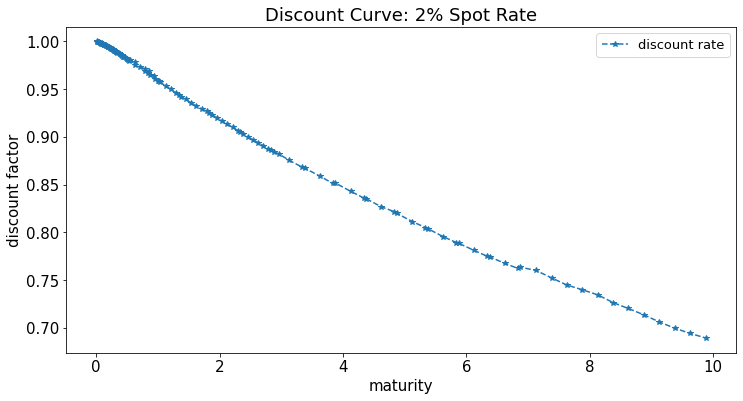

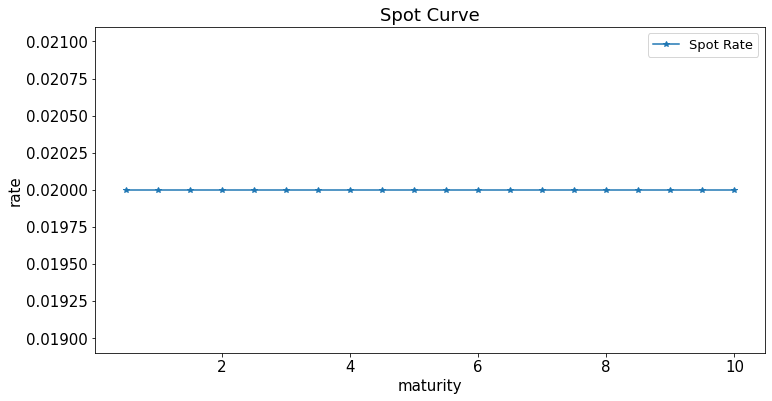

In [181]:
# Construct metrics dataframe
metrics = rawdata.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','ytm','duration','outstanding']
metrics['ytm'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity'] = get_maturity_delta(metrics['maturity date'], CURRENT_DATE)
metrics['price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['ask-bid'] = rawdata['TDASK'] - rawdata['TDBID']
metrics['next cashflow date'] = (calc_cashflows(rawdata) != 0).idxmax(1)
metrics = metrics[['issue date','maturity date','maturity','coupon rate','next cashflow date','price','ytm','ask-bid', 'duration']]

# Update treasuries to use when calculating cashflows
MODEL = bootstrap
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=CURRENT_DATE, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
# CF = calc_cashflows(data)
# display(CF.columns)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

# Estimate the rate curve
prices = metrics['price'][CF.index]
params_OLS = estimate_rate_curve(MODEL,CF,CURRENT_DATE,prices)

# label = 'no non-maturity dates'
# CFset[label] = CF

disc_ols = pd.DataFrame({'maturity':params_OLS[0], 'discount rate': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: 2% Spot Rate')
plt.show()

inc = .5

# Question for the group? How can you set spot rate to calculate discount curve when the discount curve is calculated first?

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['Spot Rate'] = 0.02

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()

## 2.3

For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use .describe() from pandas.)

In [82]:
def nelson_siegel(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate

def price_with_rate_model(params,CF,t_current,fun_model, convert_to_discount=True, price_coupons=False):

    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = 0.02 #intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price

def intrate_to_discount(intrate, maturity, n_compound=None):
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount    

In [83]:
MODEL = nelson_siegel

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=CURRENT_DATE, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]

params = estimate_rate_curve(nelson_siegel,CF,CURRENT_DATE,prices)
CF_prices = price_with_rate_model(params,CF,CURRENT_DATE,MODEL,price_coupons=True)
model_prices = CF_prices.sum(axis=1)

CF_wts = CF_prices.div(model_prices,axis=0)
# display(CF_wts.iloc[-5:,-10:].style.format('{:.2%}'))

CF_intervals = get_maturity_delta(CF.columns.to_series(),CURRENT_DATE)
model_duration = (CF_wts * CF_intervals).sum(axis=1)
display(model_duration)

C:\Users\madrs\AppData\Local\Temp\ipykernel_8212\2605554232.py:19: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))


KYTREASNO
207892     0.010951
207774     0.016427
207893     0.030116
207868     0.035592
207430     0.041068
            ...    
207763    23.643421
207808    23.960965
207849    23.592046
207891    22.793394
207934    22.888980
Length: 378, dtype: float64

In [84]:
model_duration.describe()

count    378.000000
mean       5.338922
std        6.402546
min        0.010951
25%        0.882381
50%        2.753615
75%        6.025275
max       24.057938
dtype: float64

## 2.4
How close are your duration estimates to the imputed durations given in the data source, (column TDDURATN)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?

In [85]:
diff_durations = metrics['duration'] - model_duration
# display(diff_durations)
diff_durations.describe()

count    378.000000
mean      -0.397590
std        0.885709
min       -3.891592
25%       -0.062438
50%       -0.002560
75%        0.000231
max        0.001308
dtype: float64

The calculated durations may differ based on how CRSP is calculating them. In this particular model, we used nelson_siegel to get the rates we needed for duration, but CRSP may be using a slightly different model.

## 2.5
Continue using your assumed discount rates of 2% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

In [137]:
prices_shifted = CF * 0.02
dr_list = [.0010, .0100]
prices_approx_convexity = pd.DataFrame(dtype=float,index=prices_shifted.index)

p = prices_shifted

for dr in dr_list:    
    dp_duration = p * (-model_duration * dr)
    dp_convexity = dp_duration + p * .5 * (CF_wts * CF_intervals**2).sum(axis=1) * dr**2

    col = f'numerical shift: {dr:.2%}'
    prices_approx_convexity[col] = p + dp_convexity
    
display(prices_approx_convexity)

C:\Users\madrs\AppData\Local\Temp\ipykernel_8212\1047406647.py:8: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  dp_duration = p * (-model_duration * dr)
C:\Users\madrs\AppData\Local\Temp\ipykernel_8212\1047406647.py:9: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  dp_convexity = dp_duration + p * .5 * (CF_wts * CF_intervals**2).sum(axis=1) * dr**2
C:\Users\madrs\AppData\Local\Temp\ipykernel_8212\1047406647.py:12: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  prices_approx_convexity[col] = p + dp_convexity


ValueError: Expected a 1D array, got an array with shape (378, 690)

# 3. Hedging Duration
Import treasury_ts_issue_duration_(207392, 207391, 207457).xlsx.

I suggest using code such as

- tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')

- tsdata.columns = tsdata.columns.str.upper()

- px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()

- duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()

## 3.1
Suppose you have a portfolio of 10,000 USD long in security 207391 on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in 207392?

(Duration is the column TDDURATN in the raw data.)

In [154]:
filepath_rawdata = '../data/treasury_ts_issue_duration_(207392, 207391, 207457).xlsx'
tsdata = pd.read_excel(filepath_rawdata,sheet_name='ts')

tsdata.columns = tsdata.columns.str.upper()

px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
px_shifted = px.shift(-1)

duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()

display(duration)

KYTREASNO,207391,207392,207457
CALDT,,,
2019-12-10,98.070312,99.656250,99.898438
2019-12-11,98.507812,100.492188,100.023438
2019-12-12,97.632812,98.687500,99.851562
2019-12-13,98.242188,99.968750,100.023438
2019-12-16,97.851562,99.210938,99.945312
...,...,...,...
2022-05-24,92.773438,85.382812,100.070312
2022-05-25,92.875000,85.531250,100.070312
2022-05-26,92.867188,84.976562,100.109375


KYTREASNO,207391,207392,207457
CALDT,,,
2019-12-10,98.507812,100.492188,100.023438
2019-12-11,97.632812,98.687500,99.851562
2019-12-12,98.242188,99.968750,100.023438
2019-12-13,97.851562,99.210938,99.945312
2019-12-16,97.742188,98.796875,99.937500
...,...,...,...
2022-05-24,92.875000,85.531250,100.070312
2022-05-25,92.867188,84.976562,100.109375
2022-05-26,92.828125,85.265625,100.078125


KYTREASNO,207391,207392,207457
CALDT,,,
2019-12-10,3266.052605,7903.462256,1079.148111
2019-12-11,3265.833486,7916.893618,1078.163983
2019-12-12,3263.262568,7884.489608,1077.140728
2019-12-13,3263.357700,7905.876689,1076.162820
2019-12-16,3259.653015,7889.683846,1073.151318
...,...,...,...
2022-05-24,2483.240992,7197.000531,203.525820
2022-05-25,2482.350822,7198.601168,202.525772
2022-05-26,2481.369771,7187.222667,201.526290


Duration is the sensitivity of an asset to a shift in the interest rate. If duration is conceptually equivalent to beta in a market regression, then in order to hedge out interest rate risk for 207391, we need to short 207392 equivalent but opposite to 207391's sensitivity. The calculation is $10,000(2475.55/7159.70) = $3457.62.

NOTE!!!
This should include units of asset because duration is risk per unit (NOT DOLLAR!). So do 10,000/price to get units, then * duration to get total sensitivity. Then divide by duration of the second asset to get units to short. Multiply by price to get dollars shorted.

## 3.2
Step through the time-series, doing the following:

1. Starting at the end of the first day, set the hedged position according to the relative given durations.
2. Use the second day's price data to evaluate the net profit or loss of the hedged position.
3. Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security 207391 to be 10,000.
4. Repeat throughout the timeseries.

Report:

- the total profit (or loss.)
- the mean, standard deviation, min, and max of the daily profit or loss.

In [170]:
hedged_value = []
pnl = []
for i in duration.index.values:
    hedged = 10000 * (duration.loc[[i], [207391]].values[0][0]/duration.loc[[i], [207392]].values[0][0])
    num_bonds_bought = hedged / px.loc[[i], [207392]].values[0][0]
    new_value = num_bonds_bought * px_shifted.loc[[i], [207392]].values[0][0]
    hedged_value.append(hedged)
    pnl.append(new_value - hedged)

duration['Hedged'] = hedged_value
duration['PNL'] = pnl
display(duration)

duration = duration.dropna()
total = duration['PNL'].sum()
print(f'The total PNL is ${total}')

duration['PNL'].describe()

KYTREASNO,207391,207392,207457,PNL,Hedged
CALDT,,,,,
2019-12-10,3266.052605,7903.462256,1079.148111,34.663711,4132.432723
2019-12-11,3265.833486,7916.893618,1078.163983,-74.081359,4125.145093
2019-12-12,3263.262568,7884.489608,1077.140728,53.734123,4138.838061
2019-12-13,3263.357700,7905.876689,1076.162820,-31.290474,4127.761953
2019-12-16,3259.653015,7889.683846,1073.151318,-17.243210,4131.538194
...,...,...,...,...,...
2022-05-23,2483.424148,7170.010199,204.526019,59.311995,3463.627078
2022-05-24,2483.240992,7197.000531,203.525820,5.998470,3450.383227
2022-05-25,2482.350822,7198.601168,202.525772,-22.363440,3448.379434


The total PNL is $-317.9861279179936


count    620.000000
mean      -0.512881
std       47.400031
min     -332.384723
25%      -28.308153
50%       -0.548143
75%       25.121756
max      333.398148
Name: PNL, dtype: float64